In [1]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Pre-processing

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv('/content/drive/MyDrive/Landmark detection/train.csv')
base_path = "/content/drive/MyDrive/Landmark detection/images/"

In [26]:
df = df.loc[df["id"].str.startswith('b1', na=False), :]
num_classes = len(df["landmark_id"].unique())

data = pd.DataFrame(df["landmark_id"].value_counts())
data.reset_index(inplace=True)

data.head()

,landmark_id,count
0,138982,30
1,10419,8
2,113209,7
3,173511,6
4,126637,6


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.783e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 4.340e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        7.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 1.900e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 1.200e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

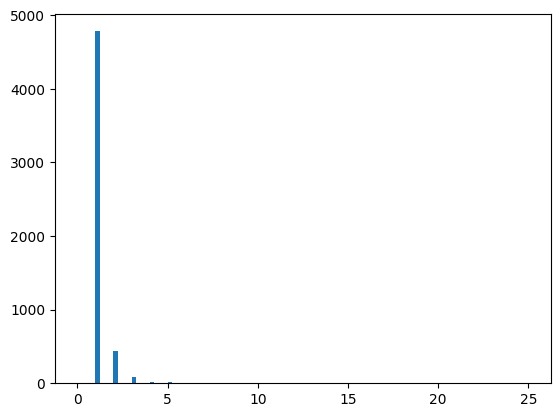

In [27]:
plt.hist(data['count'], 100, range= (0,25), label= 'test')

(array([3., 0., 1., ..., 0., 4., 2.]),
 array([2.70000000e+01, 6.50614808e+01, 1.03122962e+02, ...,
        2.03008877e+05, 2.03046939e+05, 2.03085000e+05]),
 <BarContainer object of 5335 artists>)

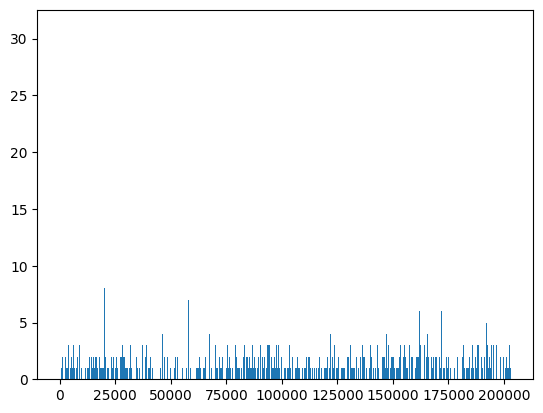

In [28]:
plt.hist(df["landmark_id"], bins=df["landmark_id"].nunique())

In [29]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [30]:
def encode_label(label):
    return lencoder.transform(label)

def decode_label(label):
    return lencoder.inverse_transform(label)

In [31]:
def get_image_from_numbers(num, df):
    row = df.iloc[num, :]
    fname = row[0] + '.jpg'
    label = row[1]
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    full_path = os.path.join(base_path, f1, f2, f3, fname)
    im = cv2.imread(full_path)
    return im, label

4 sample Images from random classes


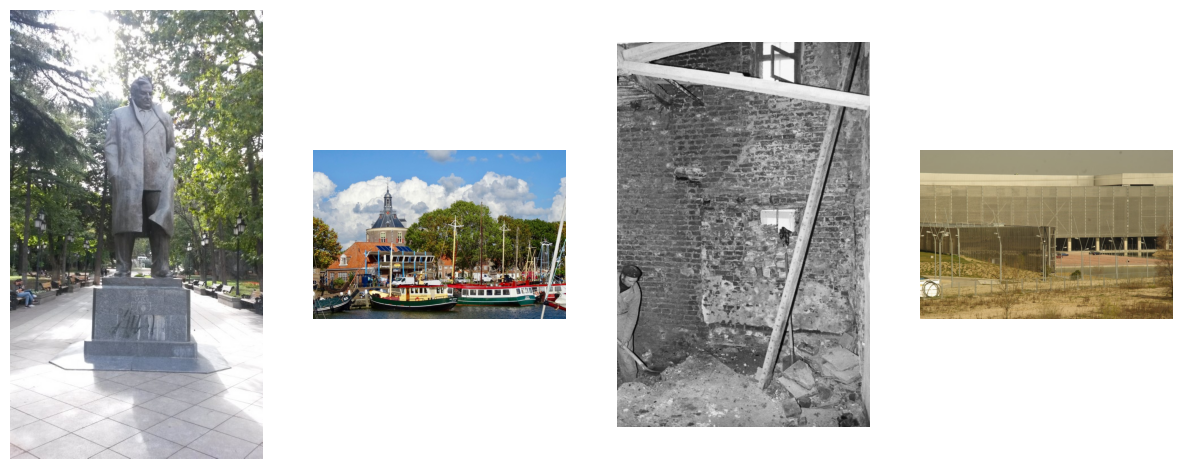

In [32]:
print("4 sample Images from random classes")
fig = plt.figure(figsize=(15,15))
for i in range(1,5):
  ri = random.choices(os.listdir(base_path), k=3)
  folder = base_path + "b/1/" + ri[2]
  random_img = random.choice(os.listdir(folder))
  img = np.array(Image.open(folder + "/" + random_img))
  fig.add_subplot(1,4,i)
  plt.imshow(img)
  plt.axis("off")
plt.show()

## Model Building and Training

In [33]:
learning_rate = 0.0001
loss_function = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
drop_layer = Dropout(0.5)

In [34]:
# model = Sequential()
# for layer in source_model.layers[:-1]:
#     if layer == source_model.layers[-25]:
#         model.add(BatchNormalization())
#     model.add(layer)
# model.add(Dense(num_classes, activation="softmax"))
# model.summary()

model = Sequential()
for layer in source_model.layers[:-14]:  # Skip the last few layers from VGG19
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                      

In [35]:
optim1 = Adam(learning_rate=learning_rate)
model.compile(optimizer=optim1, loss=loss_function, metrics=["accuracy"])

In [36]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

In [37]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []

    end_img = start + batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)

    for idx in range(start, end_img):
        im, label = get_image_from_numbers(idx, dataframe)
        if im is None or im.size == 0:
            print(f"Warning: Empty image encountered at index {idx}")
            continue
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)

In [38]:
batch_size = 16
epoch_shuffle = True
epochs = 1

train, val = np.split(df.sample(frac=1), [int(0.8 * len(df))])

In [39]:
for e in range(epochs):
    print("Epoch :" + str(e + 1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac=1)
    for it in range(int(np.ceil(len(train) / batch_size))):
        X_train, y_train = get_batch(train, it * batch_size, batch_size)
        loss, accuracy = model.train_on_batch(X_train, y_train)
    print(f"Loss: {loss}, Accuracy: {accuracy}")


model.save("Model.h5")

Epoch :1/1
Loss: 8.593191146850586, Accuracy: 0.0


In [40]:
errors = 0
good_preds = []
bad_preds = []

for it in range(int(np.ceil(len(val) / batch_size))):
    X_val, y_val = get_batch(val, it * batch_size, batch_size)
    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors += 1
            bad_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size * it + idx, cla[idx], res[cla[idx]]])

1/1 [==============================] - 0s 82ms/step


In [42]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))

len(good_preds)

10

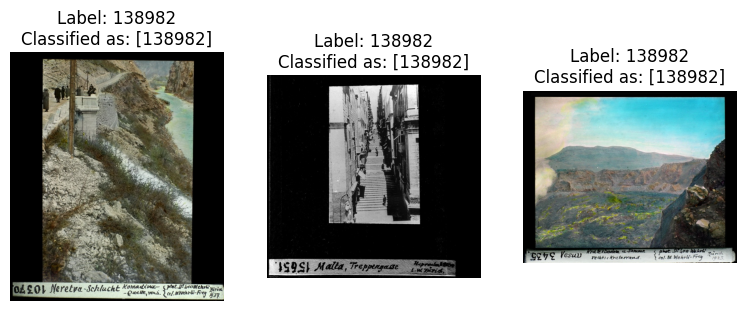

In [44]:
# Visualizing good predictions
good_preds = np.array(sorted(good_preds, key=lambda x: x[2], reverse=True))

fig = plt.figure(figsize=(16, 16))
for i in range(7, 10):
    n = int(good_preds[i, 0])
    img, lbl = get_image_from_numbers(n, val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i - 6)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i, 1])).reshape(1, 1)
    plt.title(f"Label: {lbl}\nClassified as: {decode_label(lbl2)}")
    plt.axis('off')
plt.show()
